<h1 style="font-family : Arial; background-color : rgb(255,102,0); color : white; border : 2px solid; text-align:center; padding-top : 20px; padding-bottom:20px">FORECASTING INCOMMING CALLS : Particulier HVC</h1>

In [1]:
import pandas as pd
import numpy as np
import os
folder_path = r'C:\Users\sst\Downloads\Time series\hebdo_data_base\APE'
files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
all_data = pd.DataFrame()
for file in files :
    file_path = os.path.join(folder_path, file)
    data = pd.read_excel(file_path)
    all_data = pd.concat([all_data, data], ignore_index=True)

In [2]:
df = all_data.copy()
df = df.set_index('upd_dt')
df.index = pd.to_datetime(df.index)
df = df[['tranche_30mn','programme','nb_appel_recu_file_attente']]

In [3]:
gp = df[df['programme']=='Particulier HVC']
gp = gp[['tranche_30mn','nb_appel_recu_file_attente']]
gp = gp.resample('D').sum(numeric_only=True)
gp_fin = gp.index.max()
gp_start = gp_fin - pd.DateOffset(days=55)
gp_8 = gp[gp.index >= gp_start]

In [4]:
gp_8.transpose()

upd_dt,2024-07-08,2024-07-09,2024-07-10,2024-07-11,2024-07-12,2024-07-13,2024-07-14,2024-07-15,2024-07-16,2024-07-17,...,2024-08-23,2024-08-24,2024-08-25,2024-08-26,2024-08-27,2024-08-28,2024-08-29,2024-08-30,2024-08-31,2024-09-01
nb_appel_recu_file_attente,334,219,211,179,210,120,82,191,183,203,...,239,190,103,261,344,320,202,194,266,87


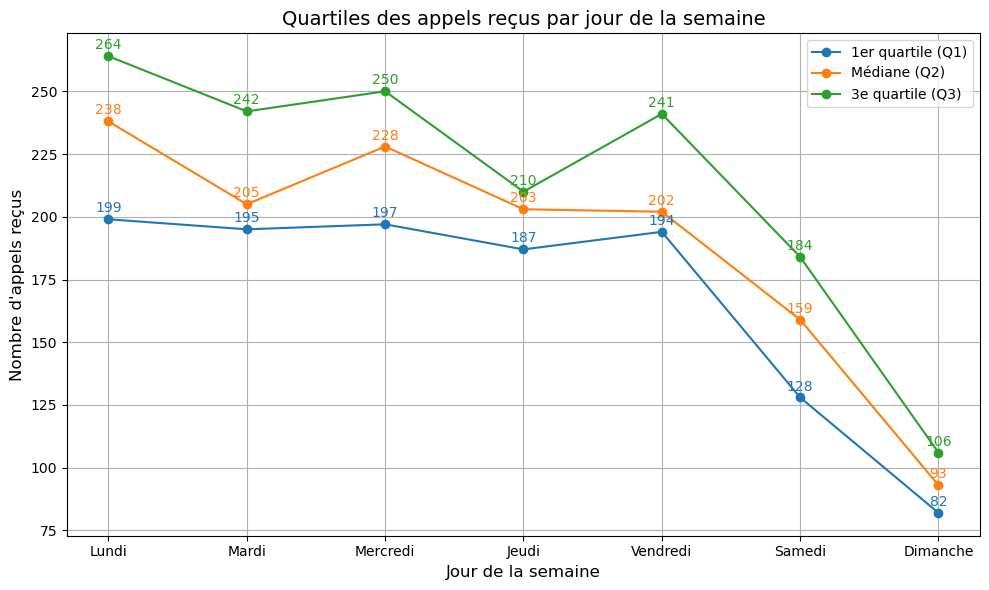

In [5]:
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True

def calculate_weekday_quartiles(data, day_of_week_column, value_column):
    quartiles = {}
    
    for day in range(7):
        day_data = data[data[day_of_week_column] == day][value_column]
        
        if not day_data.empty:
            Q1 = round(day_data.quantile(0.25))  # Premier quartile (Q1)
            Q2 = round(day_data.median())        # Médiane (Q2)
            Q3 = round(day_data.quantile(0.75))  # Troisième quartile (Q3)
            
            quartiles[day] = {'Q1': Q1, 'Q2': Q2, 'Q3': Q3}
        else:
            quartiles[day] = {'Q1': None, 'Q2': None, 'Q3': None}  
    
    return quartiles

# Vérification du type de l'index et conversion en datetime si nécessaire
if not pd.api.types.is_datetime64_any_dtype(gp_8.index):
    gp_8.index = pd.to_datetime(gp_8.index)

gp_8['jour_semaine'] = gp_8.index.weekday

# Calcul des quartiles pour chaque jour de la semaine
quartiles_per_day = calculate_weekday_quartiles(gp_8, 'jour_semaine', 'nb_appel_recu_file_attente')

# Préparation des données pour l'affichage
jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
Q1_values, Q2_values, Q3_values = [], [], []

for day in range(7):
    quartiles = quartiles_per_day[day]
    Q1_values.append(quartiles['Q1'])
    Q2_values.append(quartiles['Q2'])
    Q3_values.append(quartiles['Q3'])

# Création de la figure et des axes pour le graphique
plt.figure(figsize=(10, 6))

# Tracé des quartiles
line_Q1, = plt.plot(jours, Q1_values, marker='o', label='1er quartile (Q1)')
line_Q2, = plt.plot(jours, Q2_values, marker='o', label='Médiane (Q2)')
line_Q3, = plt.plot(jours, Q3_values, marker='o', label='3e quartile (Q3)')

# Récupération des couleurs des lignes
color_Q1 = line_Q1.get_color()
color_Q2 = line_Q2.get_color()
color_Q3 = line_Q3.get_color()

# Ajout d'annotations pour chaque point avec des valeurs arrondies et des couleurs correspondantes
for i, (q1, q2, q3) in enumerate(zip(Q1_values, Q2_values, Q3_values)):
    if q1 is not None:
        plt.annotate(f'{q1}', (jours[i], q1), textcoords="offset points", xytext=(0, 5), ha='center', color=color_Q1, fontsize=10)
    if q2 is not None:
        plt.annotate(f'{q2}', (jours[i], q2), textcoords="offset points", xytext=(0, 5), ha='center', color=color_Q2, fontsize=10)
    if q3 is not None:
        plt.annotate(f'{q3}', (jours[i], q3), textcoords="offset points", xytext=(0, 5), ha='center', color=color_Q3, fontsize=10)

# Ajout des titres, étiquettes et légende
plt.title("Quartiles des appels reçus par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Nombre d'appels reçus", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Affichage du graphique
plt.tight_layout()  # Pour améliorer l'affichage des éléments
plt.show()

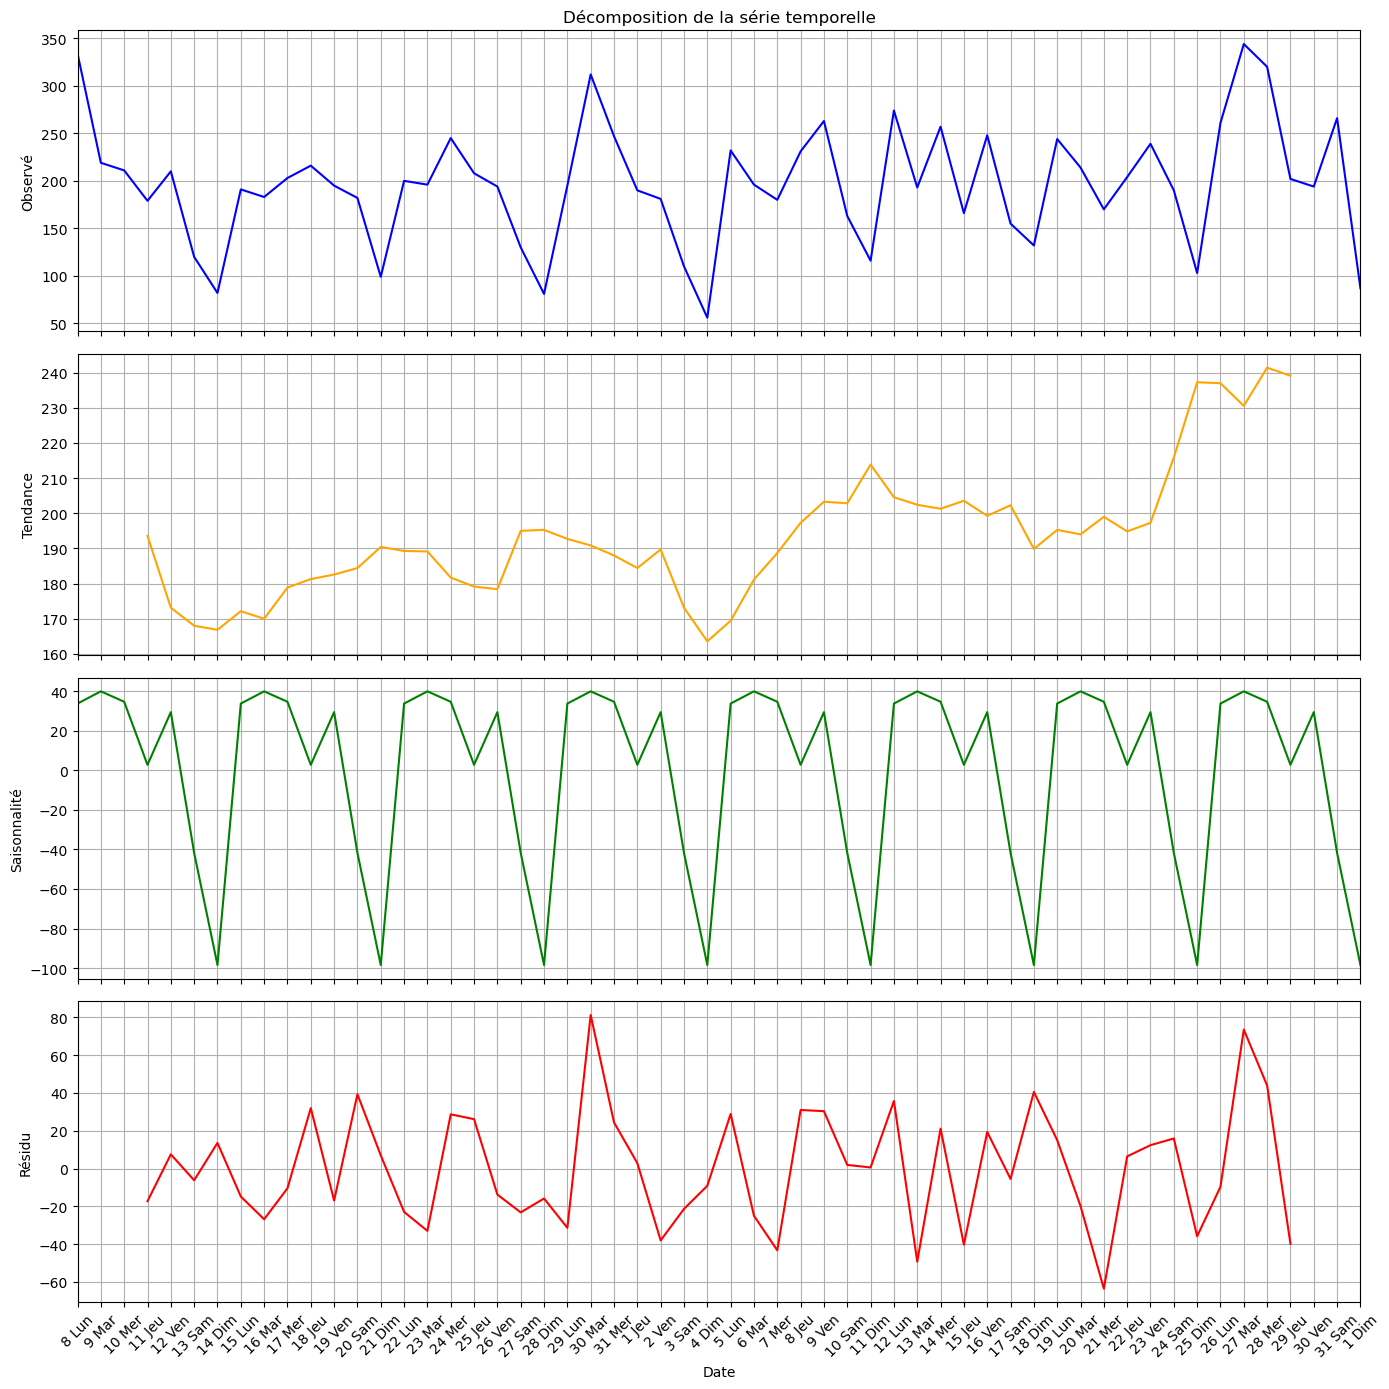

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Copie de la DataFrame (assurez-vous que 'nb_appel_recu_file_attente' est bien une série temporelle)
y = gp_8['nb_appel_recu_file_attente'].copy()

# Vérifiez que la série temporelle a une fréquence définie
if not y.index.inferred_freq:
    y = y.asfreq('D')  # 'D' pour fréquence journalière (à ajuster selon votre fréquence réelle)

# Décomposition de la série temporelle
decomposition = seasonal_decompose(y, model='additive')

# Création des sous-graphiques
fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# Tracé de chaque composante
decomposition.observed.plot(ax=axs[0], color='blue')
axs[0].set_ylabel('Observé')
axs[0].set_title('Décomposition de la série temporelle')
axs[0].grid(True)

decomposition.trend.plot(ax=axs[1], color='orange')
axs[1].set_ylabel('Tendance')
axs[1].grid(True)

decomposition.seasonal.plot(ax=axs[2], color='green')
axs[2].set_ylabel('Saisonnalité')
axs[2].grid(True)

decomposition.resid.plot(ax=axs[3], color='red')
axs[3].set_ylabel('Résidu')
axs[3].set_xlabel('Date')
axs[3].grid(True)

# Fonction pour formater les labels de date
def format_date_labels(ax, dates):
    day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
    labels = [f"{date.day} {day_names[date.weekday()]}" for date in dates]
    ax.set_xticks(dates)
    ax.set_xticklabels(labels, rotation=45)

# Appliquer les labels de date seulement au dernier sous-graphe (celui avec l'axe des x partagé)
format_date_labels(axs[3], y.index)

# Ajustement des espacements
plt.tight_layout()

# Afficher le graphique
plt.show()

<h1>Holt-Winters</h1>

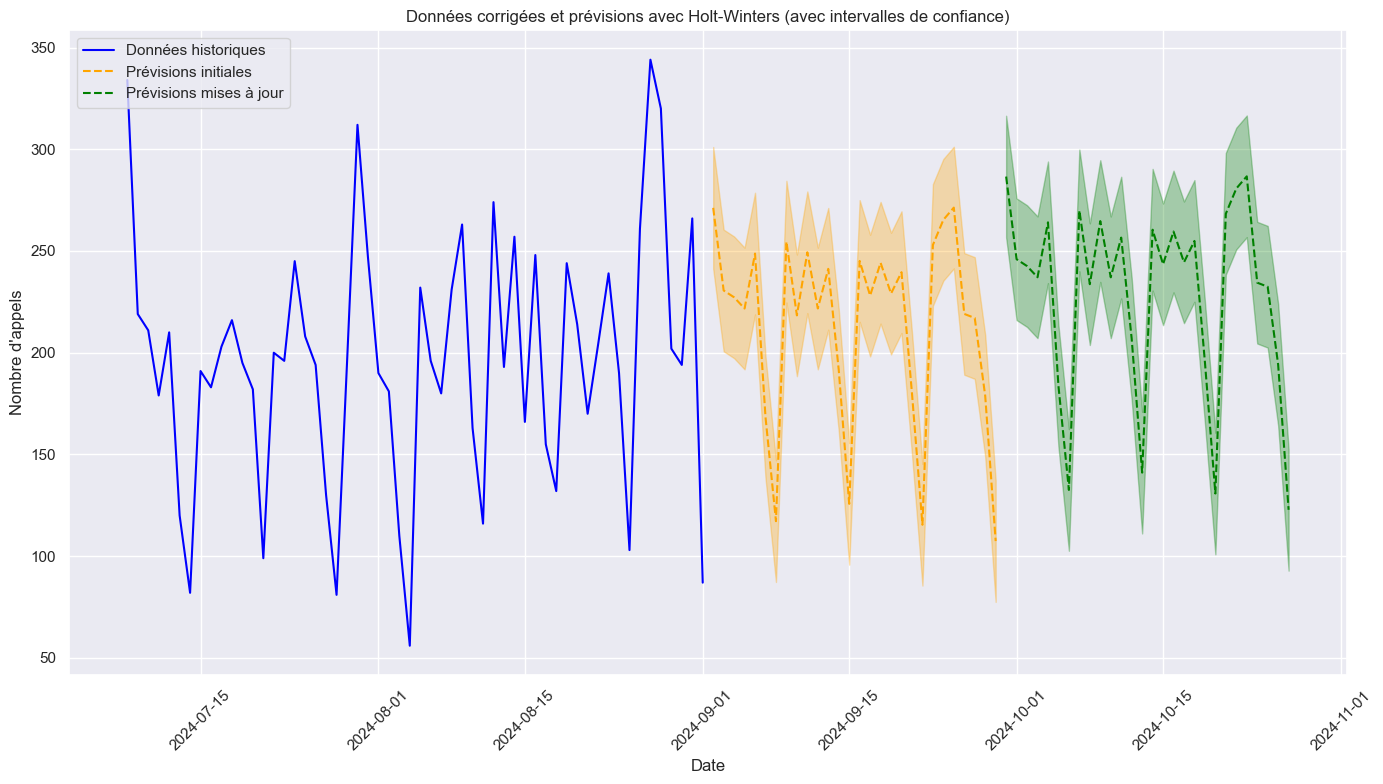

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assurez-vous que la fréquence est bien définie
if not gp_8.index.inferred_freq:
    gp_8 = gp_8.asfreq('D')

# Calcul des quartiles pour chaque jour de la semaine
quartiles_per_day = {}
for day in range(7):
    daily_data = gp_8[gp_8.index.dayofweek == day]['nb_appel_recu_file_attente']
    Q1 = daily_data.quantile(0.25)
    Q3 = daily_data.quantile(0.75)
    quartiles_per_day[day] = {'Q1': Q1, 'Q3': Q3}

# Correction des données historiques en fonction des quartiles
def correct_historical_data(df, quartiles_per_day):
    df['corrected_data'] = df.apply(
        lambda row: min(max(row['nb_appel_recu_file_attente'], quartiles_per_day[row.name.dayofweek]['Q1']),
                        quartiles_per_day[row.name.dayofweek]['Q3']),
        axis=1
    )
    return df

# Appliquer la correction aux données historiques
gp_8 = correct_historical_data(gp_8, quartiles_per_day)

# Ajuster le modèle Holt-Winters sur les données corrigées
model_hw_corrected = ExponentialSmoothing(gp_8['corrected_data'], 
                                          trend='add', 
                                          seasonal='add', 
                                          seasonal_periods=28)

model_hw_fit_corrected = model_hw_corrected.fit()

# Calcul des résidus pour estimer l'écart-type des erreurs
residuals = gp_8['corrected_data'] - model_hw_fit_corrected.fittedvalues
residual_std = residuals.std()

# Prévisions initiales de 28 jours
forecast_steps = 28
forecast_hw_corrected = model_hw_fit_corrected.forecast(steps=forecast_steps)

# Calcul des intervalles de confiance (approximativement 95%)
z = 1.96  # Coefficient pour un intervalle de confiance à 95%
conf_int_lower = forecast_hw_corrected - z * residual_std
conf_int_upper = forecast_hw_corrected + z * residual_std

# Créer un DataFrame pour les prévisions
forecast_hw_df = pd.DataFrame({
    'nb_appel_recu_file_attente': forecast_hw_corrected,
    'conf_lower': conf_int_lower,
    'conf_upper': conf_int_upper
}, index=pd.date_range(start=gp_8.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D'))

# Créer une série étendue avec les données corrigées et les prévisions
extended_series = pd.concat([gp_8['corrected_data'], forecast_hw_df['nb_appel_recu_file_attente']], axis=0)

# Ajuster de nouveau le modèle Holt-Winters sur la série étendue
model_hw_updated = ExponentialSmoothing(extended_series, 
                                        trend='add', 
                                        seasonal='add', 
                                        seasonal_periods=28)

model_hw_fit_updated = model_hw_updated.fit()

# Prévisions mises à jour pour 28 jours supplémentaires
forecast_hw_updated = model_hw_fit_updated.forecast(steps=forecast_steps)

# Calcul des intervalles de confiance pour les prévisions mises à jour
conf_int_lower_updated = forecast_hw_updated - z * residual_std
conf_int_upper_updated = forecast_hw_updated + z * residual_std

# Créer un DataFrame pour les prévisions mises à jour
forecast_hw_updated_df = pd.DataFrame({
    'nb_appel_recu_file_attente': forecast_hw_updated,
    'conf_lower': conf_int_lower_updated,
    'conf_upper': conf_int_upper_updated
}, index=pd.date_range(start=forecast_hw_df.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D'))

# Appliquer un style Seaborn
sns.set(style="darkgrid")

# Préparer les graphiques
plt.figure(figsize=(14, 8))

# Affichage des données historiques corrigées avec Seaborn
sns.lineplot(x=gp_8.index, y=gp_8['nb_appel_recu_file_attente'], label='Données historiques', color='blue')

# Affichage des prévisions initiales avec intervalle de confiance
sns.lineplot(x=forecast_hw_df.index, y=forecast_hw_df['nb_appel_recu_file_attente'], label='Prévisions initiales', color='orange', linestyle='--')
plt.fill_between(forecast_hw_df.index, forecast_hw_df['conf_lower'], forecast_hw_df['conf_upper'], color='orange', alpha=0.3)

# Affichage des prévisions mises à jour avec intervalle de confiance
sns.lineplot(x=forecast_hw_updated_df.index, y=forecast_hw_updated_df['nb_appel_recu_file_attente'], label='Prévisions mises à jour', color='green', linestyle='--')
plt.fill_between(forecast_hw_updated_df.index, forecast_hw_updated_df['conf_lower'], forecast_hw_updated_df['conf_upper'], color='green', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.title('Données corrigées et prévisions avec Holt-Winters (avec intervalles de confiance)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Ajuster la disposition et afficher le graphique
plt.tight_layout()
plt.show()

In [8]:
forecast_hw_df.resample('W-SUN').sum()

,nb_appel_recu_file_attente,conf_lower,conf_upper
2024-09-08,1485.020412,1275.729013,1694.311810
2024-09-15,1502.573213,1293.281815,1711.864612
2024-09-22,1481.549767,1272.258368,1690.841165
2024-09-29,1511.954990,1302.663591,1721.246388


In [9]:
forecast_hw_updated_df.resample('W-SUN').sum()

,nb_appel_recu_file_attente,conf_lower,conf_upper
2024-10-06,1592.489212,1383.197813,1801.780610
2024-10-13,1609.953325,1400.661926,1819.244723
2024-10-20,1589.051811,1379.760413,1798.343210
2024-10-27,1619.484679,1410.193281,1828.776078


<h1>HEBDOMADAIRE</h1>

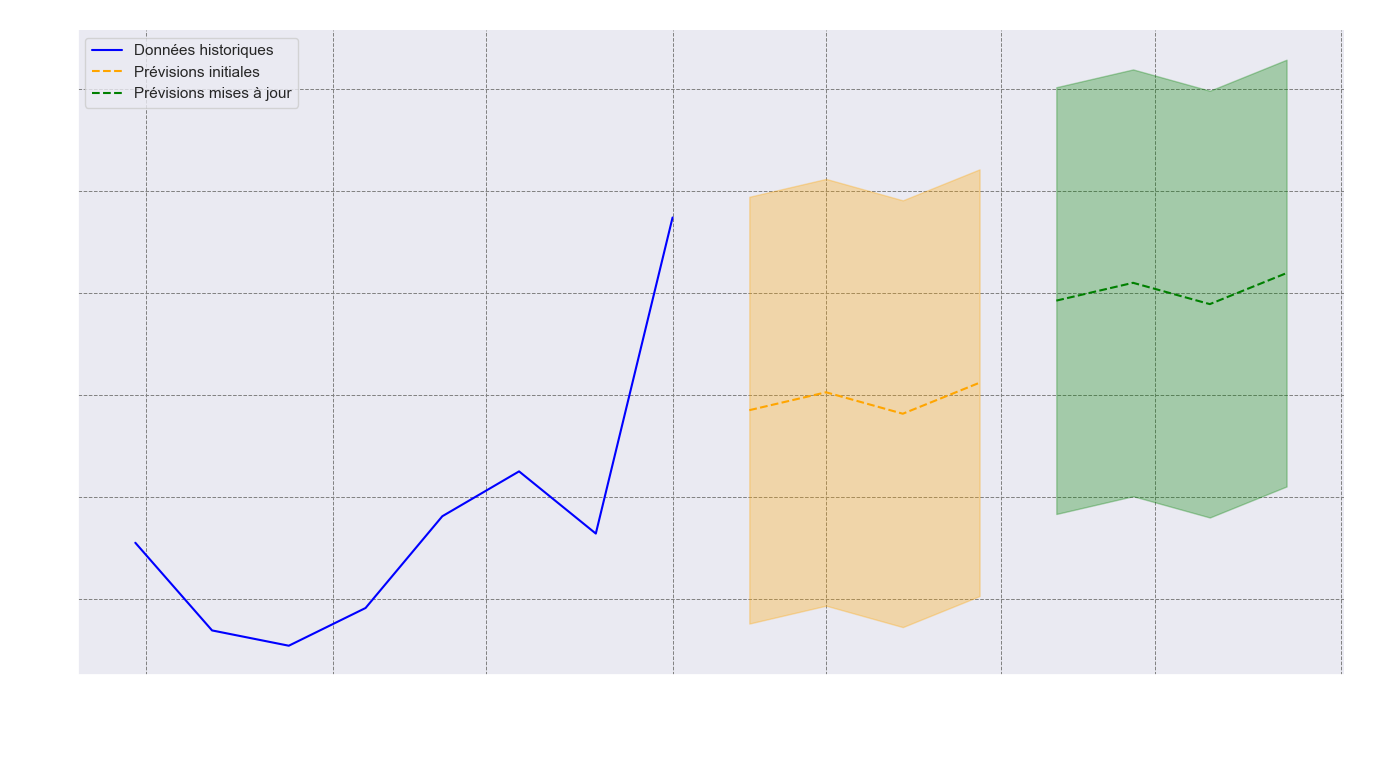

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

gp_14 = gp_8[['nb_appel_recu_file_attente']]
gp_14 = gp_14.resample('W-SUN').sum()
forecast_hw_df_4 = forecast_hw_df.resample('W-SUN').sum()
forecast_hw_updated_df_4 = forecast_hw_updated_df.resample('W-SUN').sum()

# Préparer le graphique
plt.figure(figsize=(14, 8))

# Affichage des données historiques resampled (gp_14)
sns.lineplot(x=gp_14.index, y=gp_14['nb_appel_recu_file_attente'], label='Données historiques', color='blue')

# Affichage des prévisions initiales resampled (forecast_hw_df_4) avec intervalle de confiance
sns.lineplot(x=forecast_hw_df_4.index, y=forecast_hw_df_4['nb_appel_recu_file_attente'], label='Prévisions initiales', color='orange', linestyle='--')
plt.fill_between(forecast_hw_df_4.index, forecast_hw_df_4['conf_lower'], forecast_hw_df_4['conf_upper'], color='orange', alpha=0.3)

# Affichage des prévisions mises à jour resampled (forecast_hw_updated_df_4) avec intervalle de confiance
sns.lineplot(x=forecast_hw_updated_df_4.index, y=forecast_hw_updated_df_4['nb_appel_recu_file_attente'], label='Prévisions mises à jour', color='green', linestyle='--')
plt.fill_between(forecast_hw_updated_df_4.index, forecast_hw_updated_df_4['conf_lower'], forecast_hw_updated_df_4['conf_upper'], color='green', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date', color='white')
plt.ylabel('Nombre d\'appels', color='white')
plt.title('Données historiques et prévisions avec Holt-Winters (avec intervalles de confiance)', color='white')
plt.legend(loc='upper left')

# Ajuster la couleur des axes et des grilles pour une meilleure lisibilité
plt.grid(True, color='gray', linestyle='--', linewidth=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.tick_params(colors='white', which='both')

# Couleur de fond sombre
# plt.gca().set_facecolor('#2E2E2E')  # Fond sombre
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')

# Ajuster la disposition et afficher le graphique
plt.tight_layout()
plt.show()

<h1>TRANCHE 30 MN</h1>

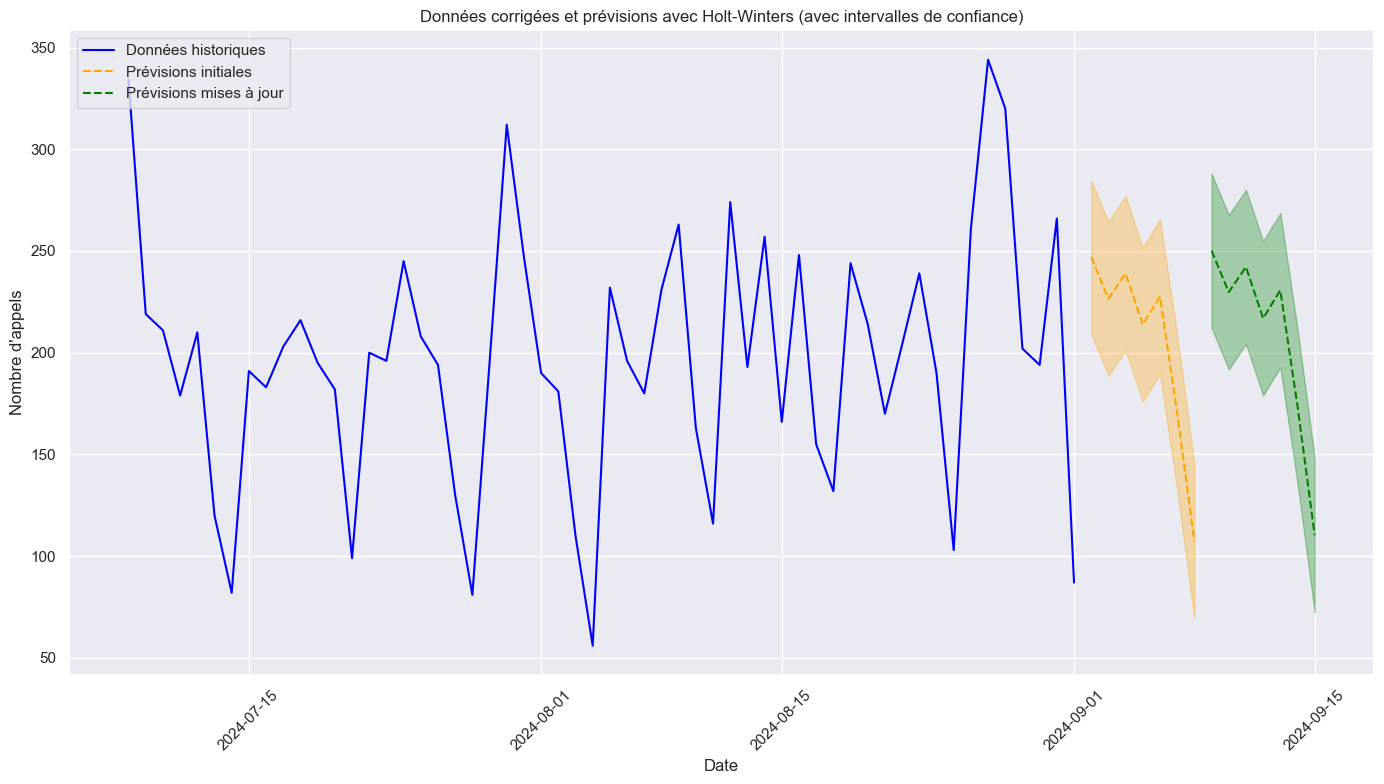

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assurez-vous que la fréquence est bien définie
if not gp_8.index.inferred_freq:
    gp_8 = gp_8.asfreq('D')

# Calcul des quartiles pour chaque jour de la semaine
q_per_day = {}
for d in range(7):
    daily_data = gp_8[gp_8.index.dayofweek == d]['nb_appel_recu_file_attente']
    Q1 = daily_data.quantile(0.25)
    Q3 = daily_data.quantile(0.75)
    q_per_day[d] = {'Q1': Q1, 'Q3': Q3}

# Correction des données historiques en fonction des quartiles
def correct_data(df, q_per_day):
    df['corr_data'] = df.apply(
        lambda row: min(max(row['nb_appel_recu_file_attente'], q_per_day[row.name.dayofweek]['Q1']),
                        q_per_day[row.name.dayofweek]['Q3']),
        axis=1
    )
    return df

# Appliquer la correction aux données historiques
gp_8 = correct_data(gp_8, q_per_day)

# Ajuster le modèle Holt-Winters sur les données corrigées
hw_model = ExponentialSmoothing(gp_8['corr_data'], 
                                trend='add', 
                                seasonal='add', 
                                seasonal_periods=7)

hw_fit = hw_model.fit()

# Calcul des résidus pour estimer l'écart-type des erreurs
resid = gp_8['corr_data'] - hw_fit.fittedvalues
resid_std = resid.std()

# Prévisions initiales de 28 jours
steps = 7
hw_forecast = hw_fit.forecast(steps=steps)

# Calcul des intervalles de confiance (approximativement 95%)
z = 1.96
conf_lower = hw_forecast - z * resid_std
conf_upper = hw_forecast + z * resid_std

# Créer un DataFrame pour les prévisions
fcst_df = pd.DataFrame({
    'forecast': hw_forecast,
    'conf_lower': conf_lower,
    'conf_upper': conf_upper
}, index=pd.date_range(start=gp_8.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D'))

# Créer une série étendue avec les données corrigées et les prévisions
ext_series = pd.concat([gp_8['corr_data'], fcst_df['forecast']], axis=0)

# Ajuster de nouveau le modèle Holt-Winters sur la série étendue
hw_model_ext = ExponentialSmoothing(ext_series, 
                                    trend='add', 
                                    seasonal='add', 
                                    seasonal_periods=7)

hw_fit_ext = hw_model_ext.fit()

# Prévisions mises à jour pour 7 jours supplémentaires
hw_forecast_ext = hw_fit_ext.forecast(steps=steps)

# Calcul des intervalles de confiance pour les prévisions mises à jour
conf_lower_ext = hw_forecast_ext - z * resid_std
conf_upper_ext = hw_forecast_ext + z * resid_std

# Créer un DataFrame pour les prévisions mises à jour
fcst_ext_df = pd.DataFrame({
    'forecast': hw_forecast_ext,
    'conf_lower': conf_lower_ext,
    'conf_upper': conf_upper_ext
}, index=pd.date_range(start=fcst_df.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D'))

# Appliquer un style Seaborn
sns.set(style="darkgrid")

# Préparer les graphiques
plt.figure(figsize=(14, 8))

# Affichage des données historiques corrigées avec Seaborn
sns.lineplot(x=gp_8.index, y=gp_8['nb_appel_recu_file_attente'], label='Données historiques', color='blue')

# Affichage des prévisions initiales avec intervalle de confiance
sns.lineplot(x=fcst_df.index, y=fcst_df['forecast'], label='Prévisions initiales', color='orange', linestyle='--')
plt.fill_between(fcst_df.index, fcst_df['conf_lower'], fcst_df['conf_upper'], color='orange', alpha=0.3)

# Affichage des prévisions mises à jour avec intervalle de confiance
sns.lineplot(x=fcst_ext_df.index, y=fcst_ext_df['forecast'], label='Prévisions mises à jour', color='green', linestyle='--')
plt.fill_between(fcst_ext_df.index, fcst_ext_df['conf_lower'], fcst_ext_df['conf_upper'], color='green', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.title('Données corrigées et prévisions avec Holt-Winters (avec intervalles de confiance)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Ajuster la disposition et afficher le graphique
plt.tight_layout()
plt.show()

In [12]:
fcst_df 

,forecast,conf_lower,conf_upper
2024-09-02,246.950175,209.038212,284.862138
2024-09-03,226.557085,188.645122,264.469048
2024-09-04,238.985383,201.073420,276.897346
2024-09-05,213.857777,175.945814,251.769740
2024-09-06,227.605882,189.693919,265.517845
2024-09-07,170.658712,132.746749,208.570675
2024-09-08,107.411049,69.499086,145.323012


In [13]:
fcst_ext_df

,forecast,conf_lower,conf_upper
2024-09-09,250.173131,212.261168,288.085094
2024-09-10,229.738775,191.826812,267.650738
2024-09-11,242.175442,204.263479,280.087405
2024-09-12,216.893318,178.981355,254.805281
2024-09-13,230.705795,192.793832,268.617758
2024-09-14,173.795914,135.883951,211.707877
2024-09-15,110.355674,72.443711,148.267637


In [14]:
gp_s = df[df['programme']=='Particulier HVC']
gp_s = gp_s[['tranche_30mn','nb_appel_recu_file_attente']]
gp_8_s = gp_s.resample('D').sum(numeric_only=True)
# gp_s_fin = gp_s.index.max()
# gp_s_start = gp_s_fin - pd.DateOffset(days=27)
# gp_8_s = gp_s[gp_s.index >= gp_s_start]

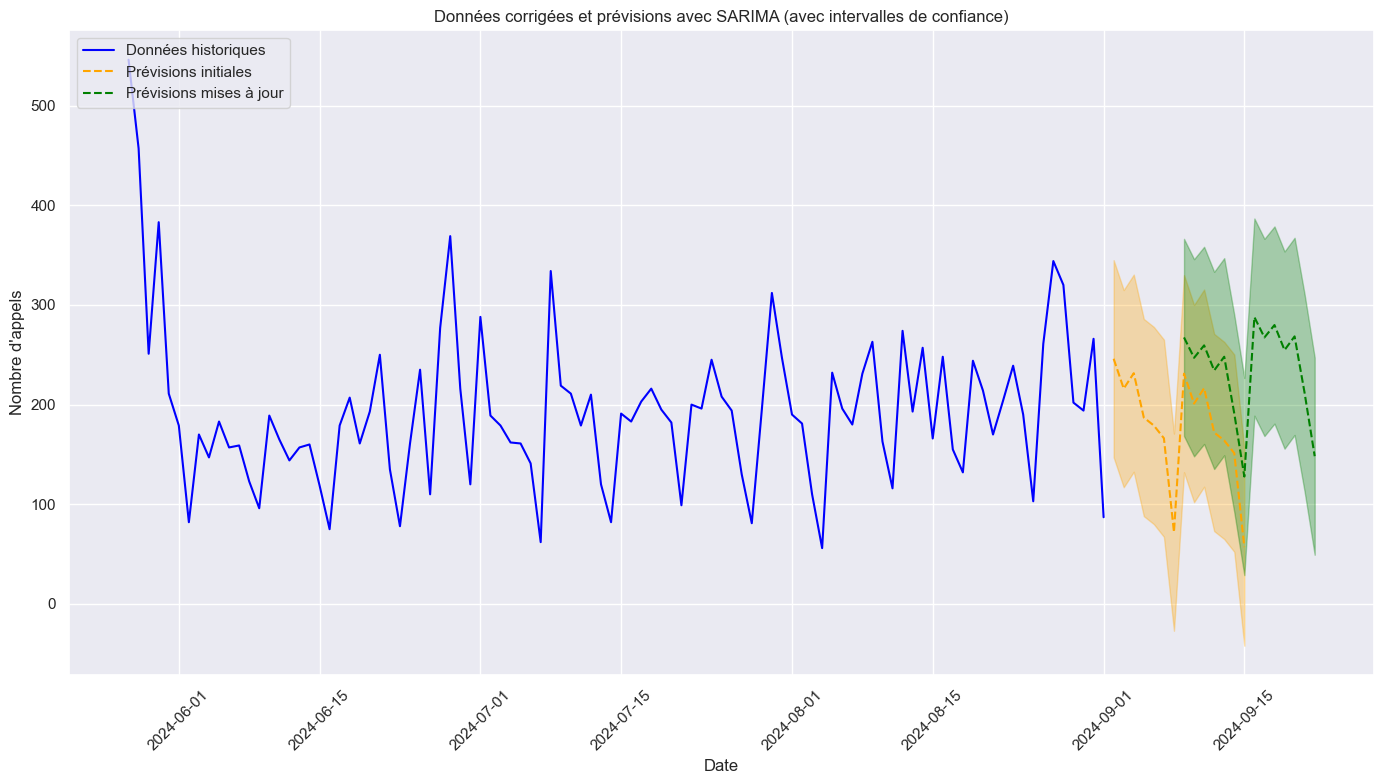

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assurez-vous que la fréquence est bien définie
if not gp_8_s.index.inferred_freq:
    gp_8_s = gp_8_s.asfreq('D')

# Calcul des quartiles pour chaque jour de la semaine
q_per_day = {}
for d in range(7):
    daily_data = gp_8_s[gp_8_s.index.dayofweek == d]['nb_appel_recu_file_attente']
    Q1 = daily_data.quantile(0.25)
    Q3 = daily_data.quantile(0.75)
    q_per_day[d] = {'Q1': Q1, 'Q3': Q3}

# Correction des données historiques en fonction des quartiles
def correct_data(df, q_per_day):
    df['corr_data'] = df.apply(
        lambda row: min(max(row['nb_appel_recu_file_attente'], q_per_day[row.name.dayofweek]['Q1']),
                        q_per_day[row.name.dayofweek]['Q3']),
        axis=1
    )
    return df

# Appliquer la correction aux données historiques
gp_8_s = correct_data(gp_8_s, q_per_day)

# Ajuster le modèle SARIMA sur les données corrigées
# Vous pouvez ajuster les paramètres p, d, q et P, D, Q, S en fonction de votre série temporelle
sarima_model = SARIMAX(gp_8_s['corr_data'],
                       order=(0, 1, 0),          # p, d, q
                       seasonal_order=(0, 1, 0, 7))  # P, D, Q, S (saison de 7 jours)

sarima_fit = sarima_model.fit()

# Calcul des résidus pour estimer l'écart-type des erreurs
resid = gp_8_s['corr_data'] - sarima_fit.fittedvalues
resid_std = resid.std()

# Prévisions initiales de 28 jours
steps = 14
sarima_forecast = sarima_fit.forecast(steps=steps)

# Calcul des intervalles de confiance (approximativement 95%)
z = 1.96
conf_lower = sarima_forecast - z * resid_std
conf_upper = sarima_forecast + z * resid_std

# Créer un DataFrame pour les prévisions
fcst_sarima_df = pd.DataFrame({
    'forecast': sarima_forecast,
    'conf_lower': conf_lower,
    'conf_upper': conf_upper
}, index=pd.date_range(start=gp_8_s.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D'))

# Créer une série étendue avec les données corrigées et les prévisions
ext_series = pd.concat([gp_8_s['corr_data'], fcst_df['forecast']], axis=0)

# Ajuster de nouveau le modèle SARIMA sur la série étendue
sarima_model_ext = SARIMAX(ext_series,
                           order=(0, 1, 0),          # p, d, q
                           seasonal_order=(0, 1, 0, 7))  # P, D, Q, S

sarima_fit_ext = sarima_model_ext.fit()

# Prévisions mises à jour pour 7 jours supplémentaires
sarima_forecast_ext = sarima_fit_ext.forecast(steps=steps)

# Calcul des intervalles de confiance pour les prévisions mises à jour
conf_lower_ext = sarima_forecast_ext - z * resid_std
conf_upper_ext = sarima_forecast_ext + z * resid_std

# Créer un DataFrame pour les prévisions mises à jour
fcst_sarima_ext_df = pd.DataFrame({
    'forecast': sarima_forecast_ext,
    'conf_lower': conf_lower_ext,
    'conf_upper': conf_upper_ext
}, index=pd.date_range(start=fcst_df.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D'))

# Appliquer un style Seaborn
sns.set(style="darkgrid")

# Préparer les graphiques
plt.figure(figsize=(14, 8))

# Affichage des données historiques corrigées avec Seaborn
sns.lineplot(x=gp_8_s.index, y=gp_8_s['nb_appel_recu_file_attente'], label='Données historiques', color='blue')

# Affichage des prévisions initiales avec intervalle de confiance
sns.lineplot(x=fcst_sarima_df.index, y=fcst_sarima_df['forecast'], label='Prévisions initiales', color='orange', linestyle='--')
plt.fill_between(fcst_sarima_df.index, fcst_sarima_df['conf_lower'], fcst_sarima_df['conf_upper'], color='orange', alpha=0.3)

# Affichage des prévisions mises à jour avec intervalle de confiance
sns.lineplot(x=fcst_sarima_ext_df.index, y=fcst_sarima_ext_df['forecast'], label='Prévisions mises à jour', color='green', linestyle='--')
plt.fill_between(fcst_sarima_ext_df.index, fcst_sarima_ext_df['conf_lower'], fcst_sarima_ext_df['conf_upper'], color='green', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.title('Données corrigées et prévisions avec SARIMA (avec intervalles de confiance)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Ajuster la disposition et afficher le graphique
plt.tight_layout()
plt.show()

In [16]:
fcst_sarima_df

,forecast,conf_lower,conf_upper
2024-09-02,246.00,147.094682,344.905318
2024-09-03,216.00,117.094682,314.905318
2024-09-04,231.50,132.594682,330.405318
2024-09-05,187.00,88.094682,285.905318
2024-09-06,179.00,80.094682,277.905318
2024-09-07,166.25,67.344682,265.155318
2024-09-08,72.00,-26.905318,170.905318
2024-09-09,231.00,132.094682,329.905318
2024-09-10,201.00,102.094682,299.905318
2024-09-11,216.50,117.594682,315.405318


In [17]:
# Ajouter une nouvelle colonne 'jour_semaine' avec les noms des jours de la semaine
fcst_sarima_df['jour_semaine'] = fcst_sarima_df.index.day_name()
fcst_sarima_s = fcst_sarima_df.tail(7)
fcst_sarima_s

,forecast,conf_lower,conf_upper,jour_semaine
2024-09-09,231.00,132.094682,329.905318,Monday
2024-09-10,201.00,102.094682,299.905318,Tuesday
2024-09-11,216.50,117.594682,315.405318,Wednesday
2024-09-12,172.00,73.094682,270.905318,Thursday
2024-09-13,164.00,65.094682,262.905318,Friday
2024-09-14,151.25,52.344682,250.155318,Saturday
2024-09-15,57.00,-41.905318,155.905318,Sunday


In [18]:
import pandas as pd

# Filtrer pour 'Particulier GP' et sélectionner les colonnes nécessaires
gp_intervalle = df[df['programme'] == 'Particulier HVC'][['tranche_30mn', 'nb_appel_recu_file_attente']]

# Définir la période des 28 jours pour les données
gp_intervalle_fin = gp_intervalle.index.max()
gp_intervalle_start = gp_intervalle_fin - pd.DateOffset(days=27)
gp_8_intervalle = gp_intervalle[gp_intervalle.index >= gp_intervalle_start]

# Ajouter une colonne 'jour_semaine'
gp_8_intervalle['jour_semaine'] = gp_8_intervalle.index.day_name()

gp_8_intervalle

,tranche_30mn,nb_appel_recu_file_attente,jour_semaine
upd_dt,,,
2024-08-05,[00:00-00:30[,0,Monday
2024-08-05,[00:30-01:00[,0,Monday
2024-08-05,[01:00-01:30[,0,Monday
2024-08-05,[01:30-02:00[,0,Monday
2024-08-05,[02:00-02:30[,0,Monday
...,...,...,...
2024-09-01,[21:30-22:00[,0,Sunday
2024-09-01,[22:00-22:30[,0,Sunday
2024-09-01,[22:30-23:00[,0,Sunday


In [19]:
import pandas as pd
import numpy as np

# Étape 1: Calculer la proportion des appels pour chaque intervalle
proportions = gp_8_intervalle.groupby('tranche_30mn')['nb_appel_recu_file_attente'].sum()
total_appels = proportions.sum()
proportions = proportions / total_appels

# Étape 2: Lissage des proportions avec une moyenne mobile (par exemple, sur 4 intervalles)
proportions_smooth = proportions.rolling(window=1, min_periods=1, center=True).mean()
proportions_smooth /= proportions_smooth.sum()  # Normaliser les proportions pour qu'elles totalisent 1

# Étape 3: Créer un DataFrame pour les prévisions
rows = []

for index, row in fcst_sarima_s.iterrows():
    jour = row['jour_semaine']
    total_prev = row['forecast']
    
    for intervalle in proportions_smooth.index:
        rows.append({
            'tranche_30mn': intervalle,
            'forecast': total_prev * proportions_smooth[intervalle],
            'jour_semaine': jour
        })

# Convertir la liste de lignes en DataFrame
forecast_intervalle = pd.DataFrame(rows)

# Étape 4: Utiliser pivot pour reformater le DataFrame
forecast_pivot = forecast_intervalle.pivot(index='tranche_30mn', columns='jour_semaine', values='forecast')

# Réorganiser les colonnes pour que les jours soient dans l'ordre souhaité
forecast_pivot = forecast_pivot[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Arrondir les valeurs vers le haut
def international_round(values):
    # Fonction qui applique l'arrondi standard (inférieur si < 0.5, supérieur si >= 0.5)
    return np.floor(values + 0.5).astype(int)

# Utilisation de la fonction sur forecast_pivot
# forecast_pivot = international_round(forecast_pivot)

# Afficher le DataFrame reformé avec les valeurs arrondies
forecast_pivot.columns.name = None

# Fonction pour colorer les cellules différentes de 0
def highlight_non_zero(s):
    return pd.DataFrame(
        [['background-color: yellow' if v != 0 else '' for v in row] for row in s.values],
        index=s.index,
        columns=s.columns
    )

# Appliquer le style conditionnel
styled_forecast_pivot = forecast_pivot.style.apply(highlight_non_zero, axis=None)

# Afficher le DataFrame stylisé
styled_forecast_pivot

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
tranche_30mn,,,,,,,
[00:00-00:30[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[00:30-01:00[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[01:00-01:30[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[01:30-02:00[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[02:00-02:30[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[02:30-03:00[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[03:00-03:30[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[03:30-04:00[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
[04:00-04:30[,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
dmt = pd.read_excel(r'C:\Users\sst\Downloads\Time series\hebdo_data_base\DMT\DMT.xlsx')
dmt = dmt.set_index('date')

In [21]:
dmt = dmt[['HVC']]

In [22]:
dmt_fin = dmt.index.max()
dmt_start = dmt_fin - pd.DateOffset(days=27)
dmt_8 = dmt[dmt.index >= dmt_start]
dmt_8

,HVC
date,
2024-07-29,177.082927
2024-07-30,185.115702
2024-07-31,167.281081
2024-08-01,175.000000
2024-08-02,157.000000
2024-08-03,165.000000
2024-08-04,144.000000
2024-08-05,159.000000
2024-08-06,179.000000


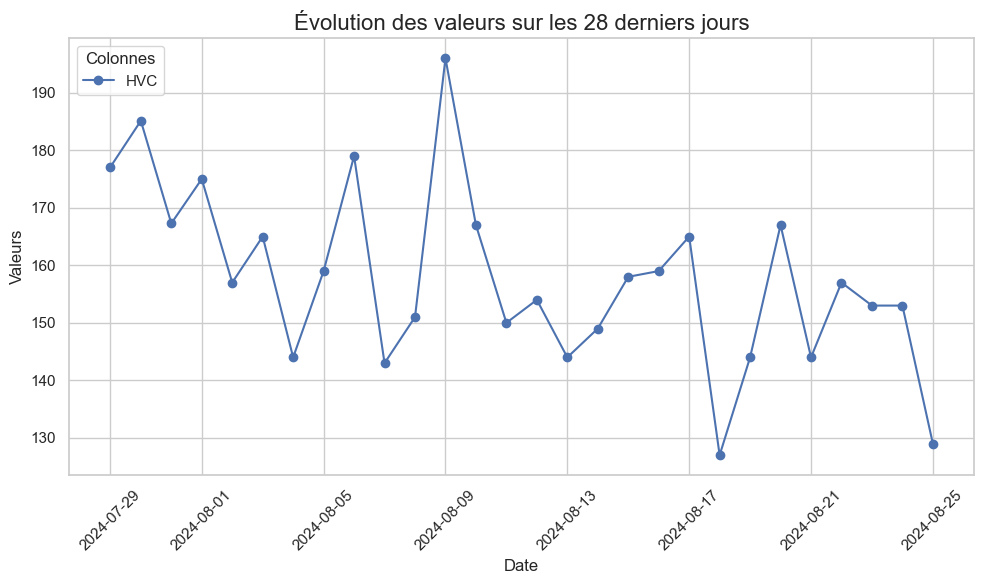

In [23]:
# Configuration générale du style des graphiques
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Tracer un graphique en ligne pour chaque colonne
for column in dmt_8.columns:
    plt.plot(dmt_8.index, dmt_8[column], marker='o', label=column)

# Ajouter des titres et des légendes
plt.title('Évolution des valeurs sur les 28 derniers jours', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Valeurs', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Colonnes", loc="upper left")
plt.tight_layout()

# Afficher le graphique
plt.show()

C:\Users\sst\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sst\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                   HVC  conf_lower  conf_upper
2024-09-02  135.547553  116.837819  154.257288
2024-09-03  145.806475  127.096741  164.516209
2024-09-04  127.846555  109.136821  146.556289
2024-09-05  137.277220  118.567486  155.986954
2024-09-06  143.276460  124.566726  161.986194
2024-09-07  139.526531  120.816797  158.236265
2024-09-08  114.529485   95.819750  133.239219


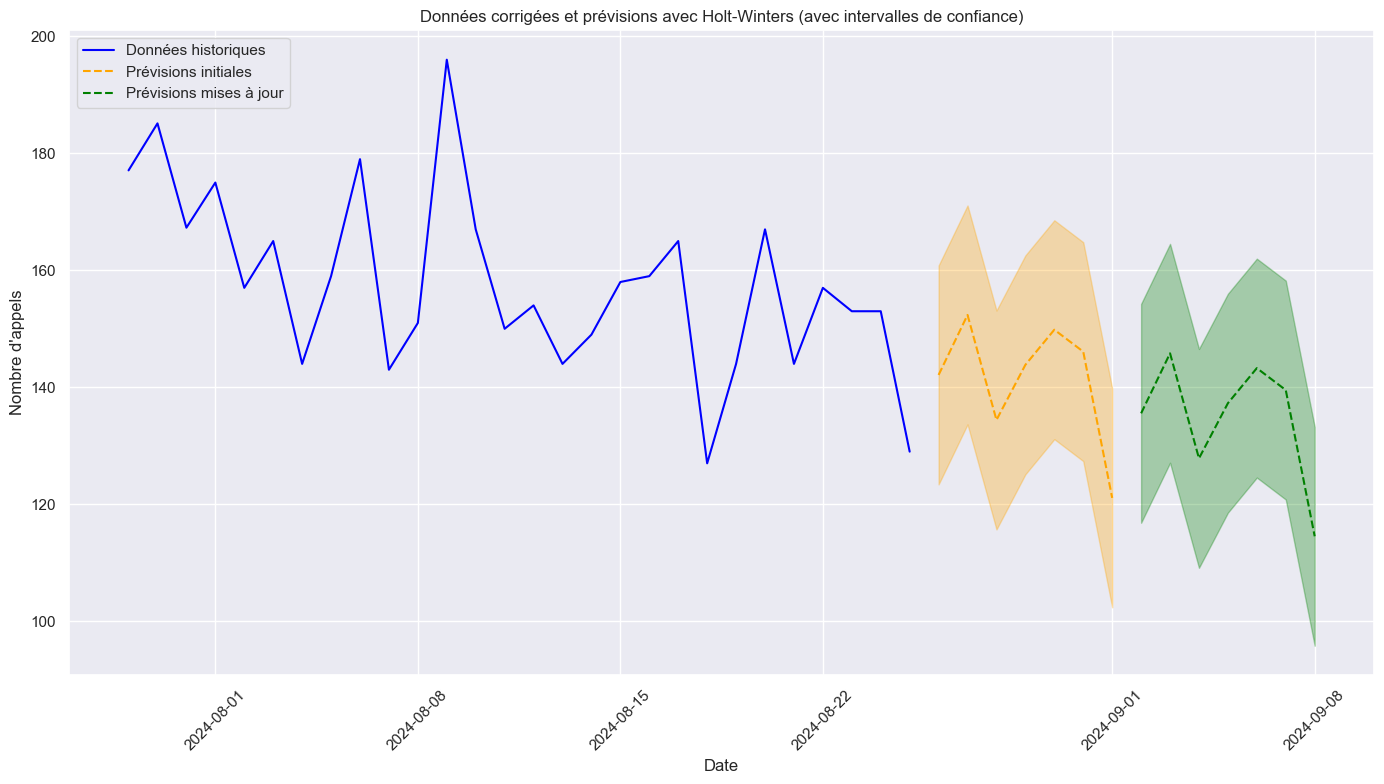

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assurez-vous que la fréquence est bien définie
if not dmt_8.index.inferred_freq:
    dmt_8 = dmt_8.asfreq('D')

# Ajuster le modèle Holt-Winters sur les données corrigées
model_hw_corrected = ExponentialSmoothing(dmt_8['HVC'], 
                                          trend='add', 
                                          seasonal='add', 
                                          seasonal_periods=7)
model_hw_fit_corrected = model_hw_corrected.fit()

# Calcul des résidus pour estimer l'écart-type des erreurs
residuals = dmt_8['HVC'] - model_hw_fit_corrected.fittedvalues
residual_std = residuals.std()

# Prévisions initiales de 7 jours
forecast_steps = 7
forecast_hw_corrected = model_hw_fit_corrected.forecast(steps=forecast_steps)

# Calcul des intervalles de confiance (approximativement 95%)
z = 1.96  # Coefficient pour un intervalle de confiance à 95%
conf_int_lower = forecast_hw_corrected - z * residual_std
conf_int_upper = forecast_hw_corrected + z * residual_std

# Créer un DataFrame pour les prévisions
forecast_hw_df_dmt = pd.DataFrame({
    'HVC': forecast_hw_corrected,
    'conf_lower': conf_int_lower,
    'conf_upper': conf_int_upper
}, index=pd.date_range(start=dmt_8.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D'))

# Créer une série étendue avec les données corrigées et les prévisions
extended_series = pd.concat([dmt_8['HVC'], forecast_hw_df_dmt['HVC']], axis=0)

# Ajuster de nouveau le modèle Holt-Winters sur la série étendue
model_hw_updated = ExponentialSmoothing(extended_series, 
                                        trend='add', 
                                        seasonal='add', 
                                        seasonal_periods=7)
model_hw_fit_updated = model_hw_updated.fit()

# Prévisions mises à jour pour 7 jours supplémentaires
forecast_hw_updated = model_hw_fit_updated.forecast(steps=forecast_steps)

# Calcul des intervalles de confiance pour les prévisions mises à jour
conf_int_lower_updated = forecast_hw_updated - z * residual_std
conf_int_upper_updated = forecast_hw_updated + z * residual_std

# Créer un DataFrame pour les prévisions mises à jour
forecast_hw_updated_df_dmt = pd.DataFrame({
    'HVC': forecast_hw_updated,
    'conf_lower': conf_int_lower_updated,
    'conf_upper': conf_int_upper_updated
}, index=pd.date_range(start=forecast_hw_df_dmt.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D'))

print(forecast_hw_updated_df_dmt)

# Appliquer un style Seaborn
sns.set(style="darkgrid")

# Préparer les graphiques
plt.figure(figsize=(14, 8))

# Affichage des données historiques corrigées avec Seaborn
sns.lineplot(x=dmt_8.index, y=dmt_8['HVC'], label='Données historiques', color='blue')

# Affichage des prévisions initiales avec intervalle de confiance
sns.lineplot(x=forecast_hw_df_dmt.index, y=forecast_hw_df_dmt['HVC'], label='Prévisions initiales', color='orange', linestyle='--')
plt.fill_between(forecast_hw_df_dmt.index, forecast_hw_df_dmt['conf_lower'], forecast_hw_df_dmt['conf_upper'], color='orange', alpha=0.3)

# Affichage des prévisions mises à jour avec intervalle de confiance
sns.lineplot(x=forecast_hw_updated_df_dmt.index, y=forecast_hw_updated_df_dmt['HVC'], label='Prévisions mises à jour', color='green', linestyle='--')
plt.fill_between(forecast_hw_updated_df_dmt.index, forecast_hw_updated_df_dmt['conf_lower'], forecast_hw_updated_df_dmt['conf_upper'], color='green', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.title('Données corrigées et prévisions avec Holt-Winters (avec intervalles de confiance)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Ajuster la disposition et afficher le graphique
plt.tight_layout()
plt.show()

<h1>Erlang C : prévision de ressource</h1>

In [25]:
dmt_erlang = forecast_hw_updated_df_dmt[['HVC']]
dmt_erlang

,HVC
2024-09-02,135.547553
2024-09-03,145.806475
2024-09-04,127.846555
2024-09-05,137.277220
2024-09-06,143.276460
2024-09-07,139.526531
2024-09-08,114.529485


In [26]:
import pandas as pd
import numpy as np
from scipy.special import factorial

# Durée moyenne d'un appel (en minutes)
average_call_duration = 6  # Changez cette valeur si nécessaire

# Taux de shrinkage par catégorie (ajustez les valeurs selon vos besoins)
shrinkage_absence_planifiee = 0.10  # Ex : 10% pour les congés
shrinkage_absence_non_planifiee = 0.05  # Ex : 5% pour les absences imprévues
shrinkage_pauses = 0.05  # Ex : 5% pour les pauses régulières
shrinkage_taches_admin = 0.05  # Ex : 5% pour les tâches non liées aux appels
shrinkage_formation = 0.05  # Ex : 5% pour les formations

shrinkage_total = (1 + shrinkage_absence_planifiee + shrinkage_absence_non_planifiee +
                   shrinkage_pauses + shrinkage_taches_admin + shrinkage_formation)

# Objectifs de niveau de service
service_level_target = 0.90  # Ex : 80% des appels doivent être pris en charge dans le délai cible
waiting_time_target = 1  # Délai d'attente du client cible en minutes

# Calcul du nombre d'agents nécessaires
def calculate_agents_needed(forecast_pivot, dmt, average_call_duration, shrinkage_total, service_level_target, waiting_time_target):
    agents_needed = pd.DataFrame(index=forecast_pivot.index, columns=forecast_pivot.columns)

    for day in forecast_pivot.columns:
        for index, row in forecast_pivot.iterrows():
            # Trafic total en Erlangs pour chaque tranche de 30 minutes
            traffic = row[day] * (average_call_duration / 60)

            # Calcul initial du nombre d'agents nécessaires (sans shrinkage)
            A = traffic  # Nombre d'appels en Erlangs
            N = int(np.ceil(A))  # Nombre initial d'agents, arrondi à l'entier supérieur

            # Fonction de calcul Erlang C
            def erlang_c(A, N):
                if N == 0:  # Éviter la division par zéro
                    return 0, 0
                numerator = (A**N / factorial(N))
                denominator = sum((A**k / factorial(k) for k in range(N))) + numerator * (1 / (1 - (A / N))) if A < N else float('inf')
                if denominator != 0:
                    probability_wait = numerator / denominator
                    waiting_time = (probability_wait * (1 - probability_wait)) / (A / N) if A > 0 else 0
                    return probability_wait, waiting_time
                else:
                    return float('inf'), float('inf')

            # Ajustement du nombre d'agents pour atteindre le niveau de service
            while True:
                probability_wait, waiting_time = erlang_c(A, N)
                if probability_wait <= (1 - service_level_target) and waiting_time <= waiting_time_target:
                    break
                N += 1

            # Appliquer le shrinkage total
            N_with_shrinkage = np.ceil(N * shrinkage_total)
            agents_needed.at[index, day] = N_with_shrinkage

    return agents_needed

# Appliquer la fonction pour obtenir le nombre d'agents nécessaires
agents_needed_df = calculate_agents_needed(forecast_pivot, dmt_erlang, average_call_duration, shrinkage_total, service_level_target, waiting_time_target)

# Fonction pour colorer les cellules
def highlight_non_zero(s):
    return pd.DataFrame(
        [['background-color: blue; color: white; font-weight: bold' if v != 0 else '' for v in row] for row in s.values],
        index=s.index,
        columns=s.columns
    )

# Convertir en entier et appliquer le style conditionnel
agents_needed_df = agents_needed_df.astype(int)
styled_agents_needed_df = agents_needed_df.style.apply(highlight_non_zero, axis=None)

# Afficher le DataFrame stylisé
styled_agents_needed_df

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
tranche_30mn,,,,,,,
[00:00-00:30[,0,0,0,0,0,0,0
[00:30-01:00[,0,0,0,0,0,0,0
[01:00-01:30[,0,0,0,0,0,0,0
[01:30-02:00[,0,0,0,0,0,0,0
[02:00-02:30[,0,0,0,0,0,0,0
[02:30-03:00[,0,0,0,0,0,0,0
[03:00-03:30[,0,0,0,0,0,0,0
[03:30-04:00[,0,0,0,0,0,0,0
[04:00-04:30[,0,0,0,0,0,0,0


<h1>OUTPUT</h1>

In [38]:
forecast_pivot.to_excel(r'C:\Users\sst\Downloads\Time series\hebdo_data_base\temp\HVC.xlsx')